In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

# Data

In [317]:
df = pd.read_csv('titanic/train.csv')
df.set_index('PassengerId', inplace=True)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [290]:
df['male'] = df['Sex'].apply(lambda x: 1 if x == 'male' else 0)
df['embarked_S'] = df['Embarked'].apply(lambda x: 1 if x == 'S' else 0)
df['embarked_C'] = df['Embarked'].apply(lambda x: 1 if x == 'C' else 0)
df['embarked_Q'] = df['Embarked'].apply(lambda x: 1 if x == 'Q' else 0)

df.drop(columns=['Sex', 'Embarked', 'Cabin', 'Ticket', 'Name'], inplace=True)

In [291]:
df[df.isnull().any(axis=1)]

,Survived,Pclass,Age,SibSp,Parch,Fare,male,embarked_S,embarked_C,embarked_Q
PassengerId,,,,,,,,,,
6,0,3,NaN,0,0,8.4583,1,0,0,1
18,1,2,NaN,0,0,13.0000,1,1,0,0
20,1,3,NaN,0,0,7.2250,0,0,1,0
27,0,3,NaN,0,0,7.2250,1,0,1,0
29,1,3,NaN,0,0,7.8792,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
860,0,3,NaN,0,0,7.2292,1,0,1,0
864,0,3,NaN,8,2,69.5500,0,1,0,0
869,0,3,NaN,0,0,9.5000,1,1,0,0


In [292]:
df['Age_imputed'] = np.where(df['Age'].isnull(), 1, 0)
df['Age'].fillna(df['Age'].mean(), inplace=True)

In [293]:
df[df.isnull().any(axis=1)]

,Survived,Pclass,Age,SibSp,Parch,Fare,male,embarked_S,embarked_C,embarked_Q,Age_imputed
PassengerId,,,,,,,,,,,


<Axes: ylabel='Frequency'>

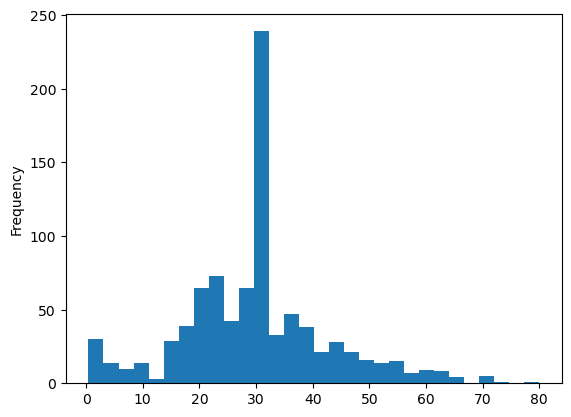

In [294]:
df['Age'].plot.hist(bins=30)

<Axes: xlabel='Survived'>

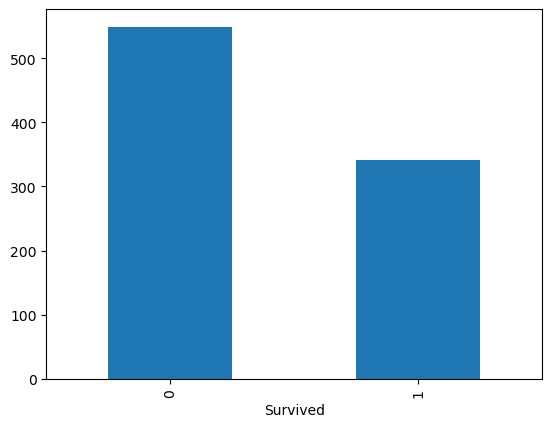

In [295]:
df['Survived'].value_counts().plot(kind='bar')

# Models

In [296]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [297]:
X = df[['Pclass', 'Age', 'Age_imputed', 'SibSp', 'Parch', 'Fare', 'male', 'embarked_S', 'embarked_C', 'embarked_Q']]
y = df[['Survived']]

In [298]:
def gridsearch(estimator, param_grid: dict, X=X, y=y):
    gs = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        n_jobs=-1,
        cv=5,
        verbose=5,
        return_train_score=True
    )
    gs.fit(X, y.values.ravel())
    results = pd.DataFrame(gs.cv_results_).sort_values(by=['mean_test_score'], ascending=False)
    print(f"Best score: {results.iloc[0]['mean_test_score']}")
    print(f"Fit time: {results.iloc[0]['mean_fit_time']}")
    print(f"Best params: {results.iloc[0]['params']}")
    return results

## Decision Tree

In [299]:
res = gridsearch(
    estimator=DecisionTreeClassifier(),
    param_grid={
        'criterion': ['gini', 'entropy', 'log_loss'],
        'splitter': ['best', 'random'],
        'max_depth': [100, 1000, None],
        'class_weight': ['balanced', None]
    }
)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best score: 0.7957880861213985
Fit time: 0.0065342426300048825
Best params: {'class_weight': None, 'criterion': 'log_loss', 'max_depth': 100, 'splitter': 'random'}


## Random Forest

In [300]:
res = gridsearch(
    estimator=RandomForestClassifier(),
    param_grid={
        'n_estimators': [10, 100, 1000],
        'criterion': ['gini', 'entropy', 'log_loss'],
        'max_depth': [1000, None]
    }
)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best score: 0.8204695248258114
Fit time: 0.02642374038696289
Best params: {'criterion': 'gini', 'max_depth': 1000, 'n_estimators': 10}


## Logistic Regression

In [301]:
res = gridsearch(
    estimator=LogisticRegression(),
    param_grid={
        'penalty': ['l2', None],
        'class_weight': ['balanced', None],
        'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        'max_iter': [10000]
    }
)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best score: 0.786761659657272
Fit time: 0.11688823699951172
Best params: {'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}


## Gradient Boosting

In [302]:
res = gridsearch(
    estimator=GradientBoostingClassifier(),
    param_grid={
        'loss': ['log_loss', 'exponential'],
        'learning_rate': [0.001, 0.01, 0.1, 1, 10],
        'n_estimators': [10, 100, 1000],
    }
)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best score: 0.8260749482141737
Fit time: 2.214206600189209
Best params: {'learning_rate': 0.01, 'loss': 'log_loss', 'n_estimators': 1000}


# Predict

In [288]:
model = GradientBoostingClassifier(
    learning_rate=0.01, loss='log_loss', n_estimators=1000
).fit(X, y.values.ravel())

In [306]:
df_test = pd.read_csv('titanic/test.csv')
df_test.set_index('PassengerId', inplace=True)

df_test['male'] = df_test['Sex'].apply(lambda x: 1 if x == 'male' else 0)
df_test['embarked_S'] = df_test['Embarked'].apply(lambda x: 1 if x == 'S' else 0)
df_test['embarked_C'] = df_test['Embarked'].apply(lambda x: 1 if x == 'C' else 0)
df_test['embarked_Q'] = df_test['Embarked'].apply(lambda x: 1 if x == 'Q' else 0)
df_test.drop(columns=['Sex', 'Embarked', 'Cabin', 'Ticket', 'Name'], inplace=True)

df_test['Age_imputed'] = np.where(df_test['Age'].isnull(), 1, 0)
df_test['Age'].fillna(df_test['Age'].mean(), inplace=True)

X_test = df_test[['Pclass', 'Age', 'Age_imputed', 'SibSp', 'Parch', 'Fare', 'male', 'embarked_S', 'embarked_C', 'embarked_Q']]
X_test[X_test.isnull().any(axis=1)]

,Pclass,Age,Age_imputed,SibSp,Parch,Fare,male,embarked_S,embarked_C,embarked_Q
PassengerId,,,,,,,,,,
1044,3,60.5,0,0,0,NaN,1,1,0,0


In [307]:
X_test.loc[1044, 'Fare'] = X_test[
    (X_test['Pclass'] == 3) & 
    (X_test['SibSp'] == 0) &
    (X_test['Parch'] == 0) &
    (X_test['male'] == 1) &
    (X_test['embarked_S'] == 1)
]['Fare'].mean()
X_test[X_test.isnull().any(axis=1)]

,Pclass,Age,Age_imputed,SibSp,Parch,Fare,male,embarked_S,embarked_C,embarked_Q
PassengerId,,,,,,,,,,


In [308]:
pred = model.predict(X_test)
pred

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [309]:
X_test.index

Index([ 892,  893,  894,  895,  896,  897,  898,  899,  900,  901,
       ...
       1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309],
      dtype='int64', name='PassengerId', length=418)

In [310]:
result = pd.DataFrame(index=X_test.index)
result['Survived'] = pred
result

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
...,...
1305,0
1306,1
1307,0


In [311]:
result.to_csv('submission.csv')

[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=100, splitter=random;, score=(train=0.987, test=0.719) total time=   0.0s
[CV 4/5] END class_weight=balanced, criterion=log_loss, max_depth=None, splitter=random;, score=(train=0.985, test=0.753) total time=   0.0s
[CV 5/5] END class_weight=None, criterion=gini, max_depth=100, splitter=best;, score=(train=0.982, test=0.820) total time=   0.0s
[CV 1/5] END class_weight=None, criterion=gini, max_depth=1000, splitter=best;, score=(train=0.985, test=0.737) total time=   0.0s
[CV 3/5] END class_weight=None, criterion=gini, max_depth=1000, splitter=random;, score=(train=0.985, test=0.798) total time=   0.0s
[CV 2/5] END class_weight=None, criterion=gini, max_depth=None, splitter=random;, score=(train=0.987, test=0.775) total time=   0.0s
[CV 3/5] END class_weight=None, criterion=gini, max_depth=None, splitter=random;, score=(train=0.985, test=0.770) total time=   0.0s
[CV 5/5] END class_weight=None, criterion=entropy, max_depth=10